# <font color='black'> Beyin Kanaması Tespiti Ön Araştırma<font>
## Content
1. #### [Gerekli Kütüphanelerin Yüklenmesi](#1)
1. #### [Veri Setinin Yüklenmesi](#2)
1. #### [Kafa İçi Beyin Kanaması Nedir? Türleri Nelerdir?](#3)
1. #### [Veri Seti Üzerinden Türlere Göre Görsellerin İncelenmesi](#4)


<a id="1"></a>
### Gerekli Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pydicom # DICOM uzantılı dosyaları yüklemek için kullanılır

import warnings
warnings.filterwarnings("ignore")

<a id="2"></a>
### Veri Setinin Yüklenmesi

In [2]:
!ls ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection

stage_2_sample_submission.csv  stage_2_test  stage_2_train  stage_2_train.csv


In [3]:
path = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_dir = "stage_2_train/"
test_dir = "stage_2_test/"
train_csv = "stage_2_train.csv"

* <p style="font-size: 1.15rem">Data içerisindeki <b>2 klasör</b> ve <b>2 csv</b> dosyası bulunmaktadır.</p>
* <p style="font-size: 1.15rem"><b>stage_2_test</b> ve <b>stage_2_train</b> klasörleri içerisinde <b>DICOM</b> dosya türünde her biri unique ID ye sahip olan CT'ler yer almaktadır.</p>
* <p style="font-size: 1.15rem"><b>stage_2_train.csv</b> train verilerinin etiketleri ve kanama türleri bulunmaktadır. Train verileri içerisindeki her bir DICOM uzantılı CT 6 adet satır kaplamaktadır.Her bir satırda <b>ID</b> ve <b>Label</b> olmak üzeri 2 sütun bulunmaktadır. ID sütunu CT'ye verilen unique ID numarasını ve beyin kanama türünü tutmaktadır. Bu satırlara karşılık bir label sütunu vardır. Label sütunu içerisinde 0 ve 1 olmak üzeri 2 değer yer almaktadır. 0 olan label değerleri o hastada belirtilen kanama türünün olmadığını göstermektedir. 1 olan değerler ise o kanama türünün belirtilen ID'de ki hastada bulunduğunu göstermektedir. 5 kanama türüne ek olarak <b>ANY</b> seçeneği de eklenmiştir. Eğer en az 1 adet kanama türü gösteren bir hasta olur ise ANY'ye karşılık gelen label değeri de 1'i göstermekte yani kanamanın var olduğunu göstermektedir.</p>
* <p style="font-size: 1.15rem">Yarışma içerisinde tahmin edilmesi istenilen 2 olay vardır.
1- Beyin kanaması var mı?
2- Hangi tür beyin kanaması var?</p>
* <p style="font-size: 1.15rem">Yarışmada başarı metriği olarak <b>weighted multi-label logarithmic los</b> kullanılmıştır</p>
* <p style="font-size: 1.15rem">Olasılık tabanlı en önemli sınıflandırma metriklerinden biridir.</p>
* <p style="font-size: 1.15rem">Daha düşük logaritmik los değeri daha iyi tahmin yapıldığı anlamına gelmektedir</p>
                                                                      


In [4]:
train = pd.read_csv(path + train_csv)
train.head(12)
# 0-5 arasındaki numaralı index'ler 1 CT'ye yani 1 görsele denk gelmektedir. 
# 0-4 arasındaki index'ler beyin kanaması türünü belirlemek için her satır 1 beyin kanaması türüne karşılık gelecek şekilde ayırt edilmiştir
# 5 numaralı index any yani beyin kanaması var ise 1 yok ise 0 olacak şekilde "Beyin kanaması var mı?" sorununa karşılık gelmektedir.

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [5]:
# Veri setinin ilk kolonundaki hasta id ve hastalık ismi ile ilgili veriler 2 kolona ayrıldı
label = train["Label"].values

In [6]:
train = train.ID.str.rsplit("_", n=1, expand=True)
train.loc[:, "label"] = label
train.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [7]:
train.rename(columns={0:"id",1:"subtype"},inplace=True)
train.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [8]:
train.shape

(4516842, 3)

In [9]:
# Daha hızlı çalışmak için veri setinden ufak bir örneklem alındı
train = train[:60000]
print(f"Örneklemin boyutu: {train.shape}")
train.head(6)

Örneklemin boyutu: (60000, 3)


,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0
5,ID_12cadc6af,any,0


In [10]:
print("Csv içerisindeki null değerler: ", train["label"].isnull().sum())
# Train csv içerisinde null değer bulunmamaktadır

Csv içerisindeki null değerler:  0


0 Etiketi Sasyısı : 56545
1 Etiketi Sayısı : 3455


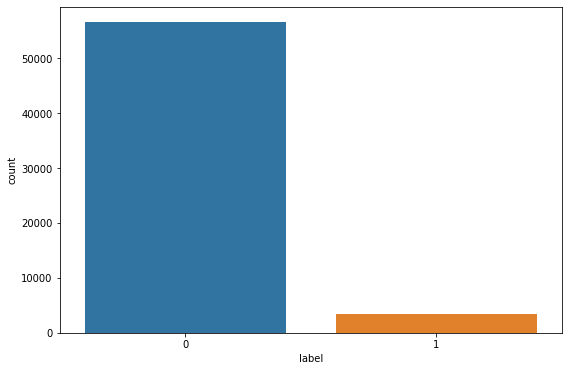

In [11]:
fig=plt.figure(figsize=(9, 6))
sns.countplot(train.label)
value_count = train.label.value_counts()
print(f"0 Etiketi Sasyısı : {value_count[0]}\n1 Etiketi Sayısı : {value_count[1]}")

In [46]:
fig=plt.figure(figsize=(9, 6))
groupBy = train.groupby("subtype").sum()
groupBy.sort_values(inplace=True)
sns.barplot(y=groupBy.index,x=groupBy.label)
groupBy

TypeError: sort_values() missing 1 required positional argument: 'by'

<Figure size 648x432 with 0 Axes>

In [13]:
# Örneklem içerisindeki hasta sayısı
hasta_listesi = train["id"].unique()
print(f"Örneklem içerisindeki hasta sayısı: {hasta_listesi.shape[0]}")
# 5 örnek hasta id'si
print(f"5 örnek hasta id {hasta_listesi[0:5]}")

Örneklem içerisindeki hasta sayısı: 9999
5 örnek hasta id ['ID_12cadc6af' 'ID_38fd7baa0' 'ID_6c5d82413' 'ID_aec8e68b3'
 'ID_4d9209c7c']


In [14]:
hasta_img = []
uzantı = ".dcm"
#counter = 0
for hasta in tqdm(hasta_listesi):
    #counter += 1
    img = path + train_dir + hasta + uzantı
    if(os.path.exists(img)):
        hasta_img.append(hasta + uzantı)
    else:
        print("hasta bulunamadı")

100%|██████████| 9999/9999 [00:44<00:00, 224.32it/s]


In [15]:
print("5 örnek train image")
hasta_img[0:5]

5 örnek train image


['ID_12cadc6af.dcm',
 'ID_38fd7baa0.dcm',
 'ID_6c5d82413.dcm',
 'ID_aec8e68b3.dcm',
 'ID_4d9209c7c.dcm']

In [16]:
print("Train içerisindeki CT sayısı: " , len(hasta_img))
# print("Test içerisindeki CT sayısı: " , len(test_images))

Train içerisindeki CT sayısı:  9999


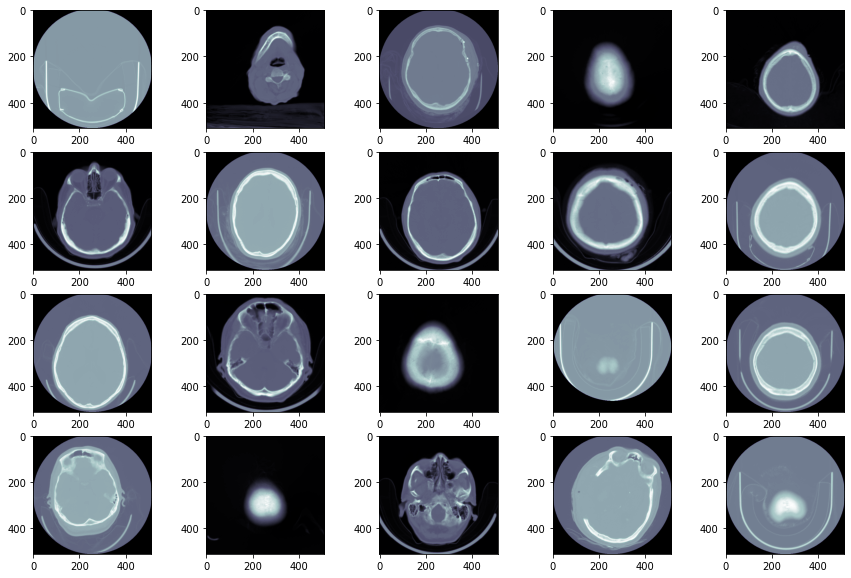

In [17]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(path + train_dir + hasta_img[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [18]:
# Dicom dosyasının içeriği
ds = pydicom.dcmread(path + train_dir + hasta_img[5])
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.49614700934198582131083896798390631633
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_559ca1f1a
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_e1f3e80e'
(0020, 000d) Study Instance UID                  UI: ID_77d8c6da6b
(0020, 000e) Series Instance UID                 UI: ID_d336fe861e
(0020, 0010) Study ID                            SH: ''
(0020, 003

In [19]:
print(ds.pixel_array.shape)

(512, 512)


<a id="4"></a>
## Kafa İçi Beyin Kanaması Türleri Nelerdir?

#### Referans: 
#### Reference of Correcting windows : https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing @Richard_McKinley

In [38]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,10))
    
    for im in range(0, height * width):
        ''''
        image = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm')).pixel_array
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')'''''
        
        data = pydicom.read_file(os.path.join(path + train_dir + images[im] + ".dcm"))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
        
    plt.suptitle(title)
    plt.show()
    

## Subdural
#### Subdural hematom, beyninizin yüzeyinde kan toplanmasıdır. Dura ve arachnoid arasında oluşur.

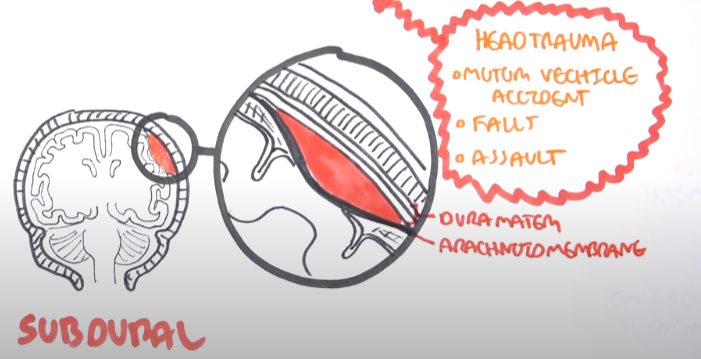

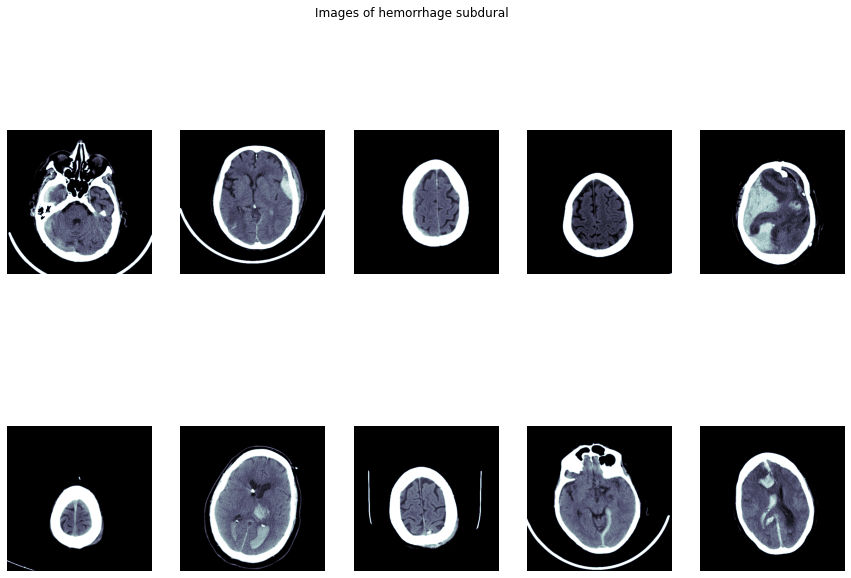

In [43]:
view_images(train[(train['subtype'] == 'subdural') & (train['label'] == 1)][:10].id.values, title = 'Images of hemorrhage subdural')

## Intraparenchymal
#### Beynin içerisinde oluşan kanamalardır.

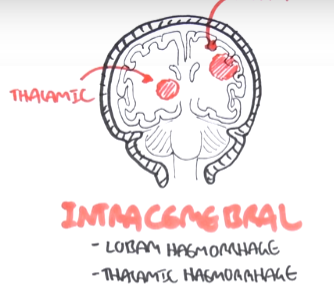

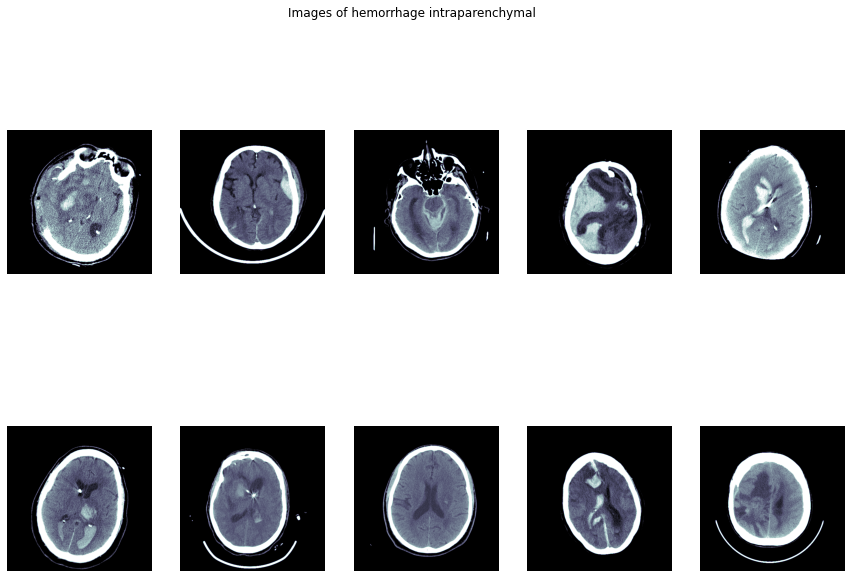

In [40]:
view_images(train[(train['subtype'] == 'intraparenchymal') & (train['label'] == 1)][:10].id.values, title = 'Images of hemorrhage intraparenchymal')

## Subarachnoid
#### Beyin sıvısı içerisine sızmış kanama türüdür. Arachnoid ve pia meter arasında kan toplanamsı ile oluşur.

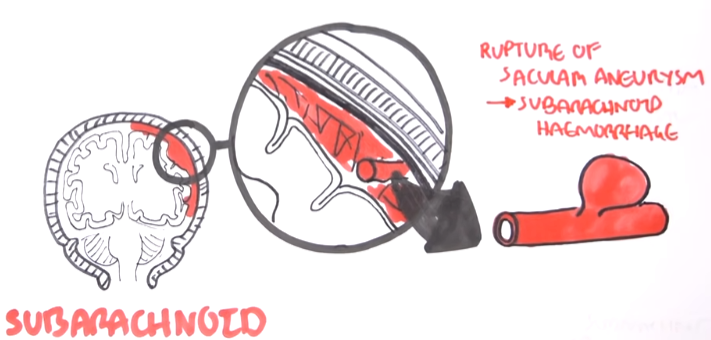

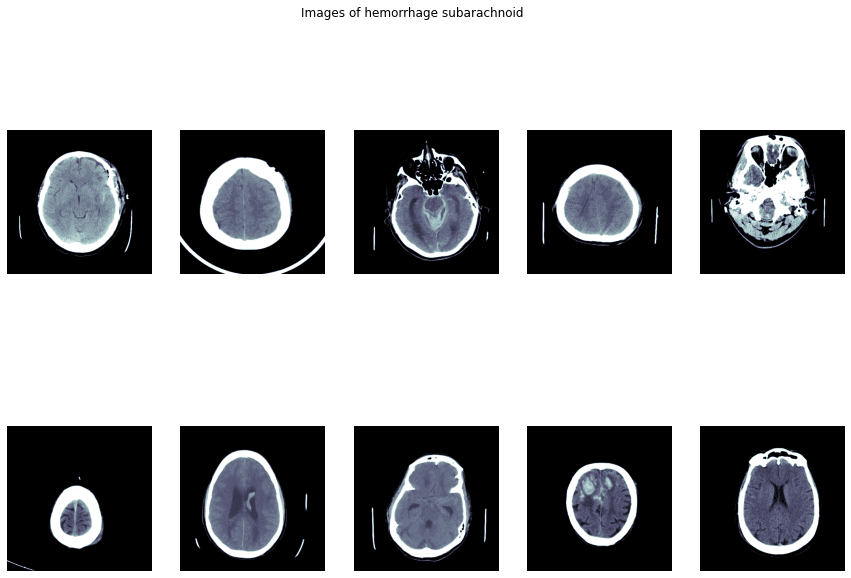

In [42]:
view_images(train[(train['subtype'] == 'subarachnoid') & (train['label'] == 1)][:10].id.values, title = 'Images of hemorrhage subarachnoid')

## Intraventricular
#### Beyin iç sıvısına sızmış kanama türüdür.

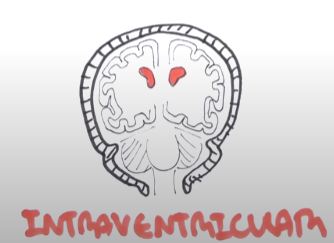

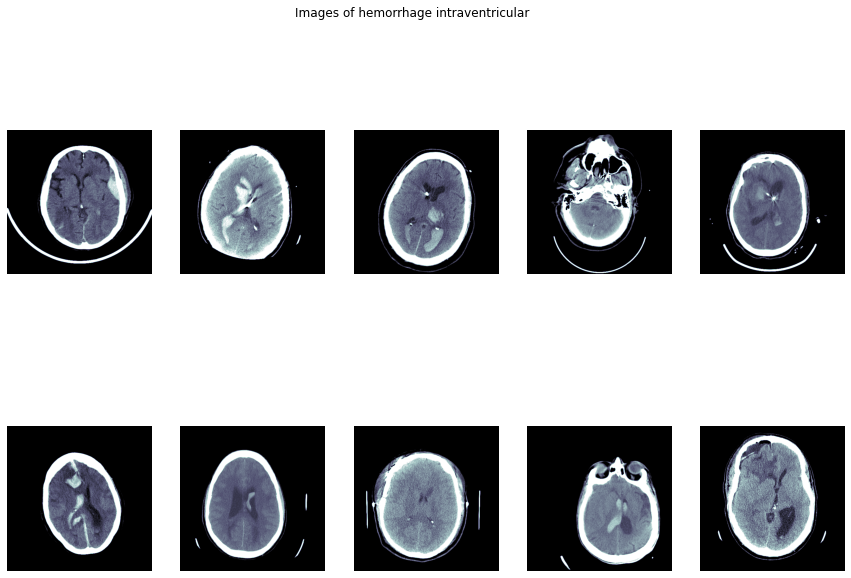

In [41]:
view_images(train[(train['subtype'] == 'intraventricular') & (train['label'] == 1)][:10].id.values, title = 'Images of hemorrhage intraventricular')

## Epidural 
#### Bir hematom, bir kan damarının dışında bir pıhtı veya top içinde bir kan topluluğudur. Epidural hematom, kafatasınız ile beyninizin en dış kaplaması arasında kan biriktiğinde meydana gelir.

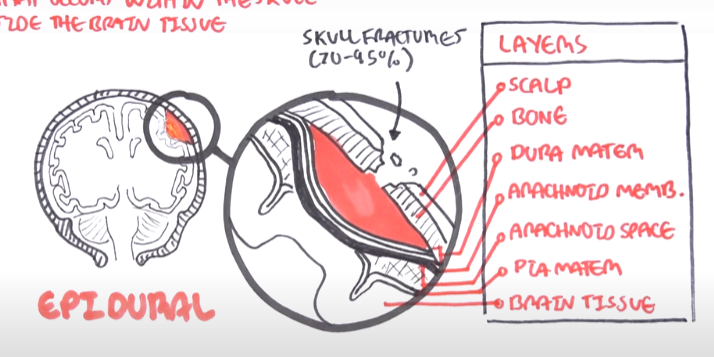

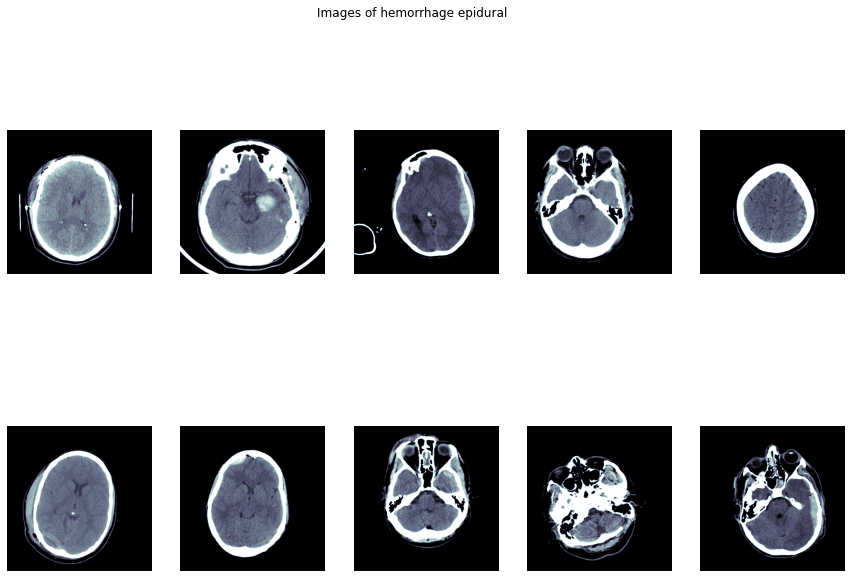

In [39]:
view_images(train[(train['subtype'] == 'epidural') & (train['label'] == 1)][:10].id.values, title = 'Images of hemorrhage epidural')